In [39]:
from __future__ import division
import matplotlib.pyplot as plt
import scipy.fft as sp 
from scipy.fft import fft, fftfreq, fftshift
from math import pi as PI
import math
import cmath
import numpy as np
from scipy import signal
import random as rand
from scipy.fftpack import fft, ifft



def step(x, *args, **kwargs):
    step_from_, step_to_ = args # откуда до куда будут ненулевые значения
                                               # + область определения функции
    print(step_from_, step_to_)
    samples_num = len(x)
    print(samples_num)
    numb_of_pts_within = 0
    
    for x_ in x:
        if step_from_<=x_<=step_to_:
            numb_of_pts_within+=1 # колво точек попадающих в область ступеньки
    
    step_height = 1/numb_of_pts_within
    y = []
    for i in range(0, len(x)):
        if step_from_<=x[i]<=step_to_:
            y.append(step_height)
        else:
            y.append(0)
        
    return y

def meander(x, *args, **kwargs):
    len_ = len(x)
    from_, to_ = args
      
    
    for i in range(0, len_):
        if from_<=x[i]<=to_:
            x[i]= 1
        else:
            x[i] = 0
    return x
   

class FuncParams:
    def __init__(self, from_, to, ampl, omega, shift, N):
        self.From = from_
        self.To = to
        self.Ampl = ampl
        self.Omega = omega
        self.shift = shift
        self.N = N

class Function :
    x = []
    y = []
    
    def __init__(self, FuncParams):
      
       self.From = FuncParams.From
       self.To = FuncParams.To
       self.W = FuncParams.Omega
       self.N = FuncParams.N
       self.Shift = FuncParams.shift
       self.Ampl = FuncParams.Ampl

    def reset_x(self):
       # self.x.clear()
         self.x = np.linspace(self.From, self.To, self.N)

    def calc(self, func, *args, **func_args):
        self.reset_x()
        #for key, val in func_args.items():
         #   print(key, val)
        
        self.y = self.Ampl*func(self.W*(self.x+self.Shift), *args, **func_args)
    def plot(self):
        fig = plt.figure()
        subplot = fig.add_subplot(111)
        subplot.plot(self.x, self.y, 'b', marker='.')
        
        
        fig.show()

    def normalize(self, value):
        len_ = len(self.y)
        for i in range (0, len_):
            self.y[i] = self.y[i]/value

    def noize(self, intensity, level):
        if intensity >=0:
            increment = 1/intensity
            len_ = len(self.y)
            x = 0
            for i in range(0, len_):
                x+=increment
                if(x>=1):
                    x=0
                    self.y[i] += rand.uniform(-level, +level)

    def reverse(self):
        # Вернуть вместо f(t) --> f(-t)
        x_ = list(self.x)
        for i in range (0, len(x_)):
            x_[i] = -x_[i]
        
        x_ = np.sort(x_)
        y_ = list(np.flip(self.y))
        res = Function(FuncParams(self.From, self.To, self.Ampl, self.W, self.Shift, self.N))
        res.x = x_
        res.y = y_
        return res

    def plot_FFT(self):
         # Частотная характеристика окна (Фильтра)
        fft_lib_res = np.fft.fft(self.y)
        spacing_period = (self.From-self.To)/self.N

        xf = fftfreq(self.N, spacing_period)
        lib_res_module = calc_module(fft_lib_res)

        fig = plt.figure()
        subplot = fig.add_subplot(111)
        subplot.set_xlim(0, max(xf))
        subplot.plot(fftshift(xf), abs(fftshift(lib_res_module))/self.N, label='Impulse characteristics')
        subplot.legend()
        fig.show()

    def FFT(self):
        fft_lib_res = np.fft.fft(self.y)
        spacing_period = (self.From-self.To)/self.N

        xf = fftfreq(self.N, spacing_period)
        return [fftshift(xf), fftshift(fft_lib_res)]

    def IFFT(self):
        ifft_y = sp.ifft(self.y)
        #spacing_period = (self.From-self.To)/self.N

        ifft_x = np.linspace(-1, 1, len(ifft_y))
        return [ifft_x, ifft_y]
        
        
def calc_module(c_res):
    res = []
    for i in c_res:
        module = (i.imag**2 + i.real**2)**0.5
        res.append(module)
    return res

def calc_and_plot(Filter_Func, Sample_Func, title):
    # Результат фильтра (Свёртка)
    conv = np.convolve(Filter_Func.y, Sample_Func.y)
    x = np.linspace(Sample_Func.From, Sample_Func.To, len(conv))
    #plt.plot(x, conv, color='r')
    
    # Частотная характеристика окна (Фильтра)
    fft_lib_res = np.fft.fft(Filter_Func.y)
    spacing_period = (Filter_Func.From-Filter_Func.To)/Filter_Func.N

    xf = fftfreq(Filter_Func.N, spacing_period)
    lib_res_module = calc_module(fft_lib_res)


    fig = plt.figure()
    fig.suptitle(title)

    # Результат сглаживания 
    subplot = fig.add_subplot(131)
    subplot.plot(Sample_Func.x, Sample_Func.y, color='b', label='Source Signal')
    subplot.plot(x, conv, color='r', label='Smoothened Signal')
    subplot.legend()

    # Фильтр
    subplot = fig.add_subplot(132)
    subplot.plot(Filter_Func.x, Filter_Func.y, color='k', label='Filter Func h(x)', marker='.')
    subplot.legend()

    # Фурье
    subplot = fig.add_subplot(133)
    #subplot.set_xlim(0, max(xf))
    subplot.plot(fftshift(xf), abs(fftshift(lib_res_module))/Filter_Func.N, label='Impulse characteristics')
    subplot.legend()
    
    fig.show()

# Скользящее окно
'''Window = Function(FuncParams(0, 3, 1, 1, 0, 100))
Window.calc(step, 1, 2)


# Шумная ступенька
meandr = Function((FuncParams(from_=0, to=3, ampl=1, omega=1, shift=0, N=500)))
meandr.calc(meander, 1, 2)
noize_level = 0.3
meandr.noize(0.2, noize_level)

calc_and_plot(Window, meandr, 'noizy step')


# Noizy sin
Omega = 2
noize_level=0.2
noize_intensity=0.15
sin_Func_a = Function((FuncParams(-np.pi*2, np.pi*2, 1, Omega, 0, 500)))
sin_Func_a.calc(np.sin)
sin_Func_a.noize(noize_intensity, noize_level)

calc_and_plot(Window, sin_Func_a, 'noizy sin, w='+str(Omega))'''


def cut_filter(x_fft, y_fft, cut_percent):
    res_y = []
    res_x = []

    middle_idx = int(len(x_fft)/2)
    max_index = int(len(y_fft)*cut_percent / 2)
    
    #print(type(x_fft), type(y_fft))
    #print('lens=', len(x_fft), len(y_fft))
    res_y = y_fft.tolist()[middle_idx - max_index : middle_idx+max_index]
    res_x = x_fft.tolist()[middle_idx - max_index : middle_idx + max_index]
    return [res_x, res_y]
    

def plot(x, y, title):
    fig = plt.figure()
    fig.suptitle(title)
    subplot = fig.add_subplot(111)
    
    subplot.plot(x, y, label='plot()')
    subplot.legend()
    fig.show()

def normalize(y, val):
    for i in range(0, len(y)):
        y[i] = y[i]/val
    return y    
    
'''# Проверка на частотную характеристику ограниченного фильтра
Filter_len_cut = 0.5 # процент, насколько усекаем множество значений импульсной характеристики (выбор длины фильтра)
Freq_character = Function((FuncParams(from_=0, to=400, ampl=1, omega=1, shift=0, N=1000)))
Freq_character.calc(meander, 0, 150)
#Freq_character.plot()


[x_fft, y_fft] = Freq_character.FFT()

fig = plt.figure()
subplot = fig.add_subplot(121)
subplot.plot(x_fft, calc_module(y_fft), label='Impulse characteristics')


[cut_fft_x, cut_fft_y] = cut_filter(x_fft, y_fft, Filter_len_cut) # срезаем часть фурье образа (выбор длины фильтра)
subplot.plot(cut_fft_x, calc_module(cut_fft_y), label='Cut Impulse characteristics', color = 'r', marker='.')

subplot.legend()'''


'''# После обратного Фурье от урезанной характеристики фильтра
res_y = np.fft.ifft(cut_fft_y)


x = np.linspace(Freq_character.From, Freq_character.To, len(res_y))


subplot = fig.add_subplot(122)
subplot.plot(x, calc_module(res_y), color = 'green', marker = '.', label = 'Cut Filter Charact')
#subplot.plot(Freq_character.x, Freq_character.y, 'r--', label='Source Filter Charact')

subplot.legend()
fig.show()'''






def calc_and_plot_filter(f_cut, filt_len, N_filt_points, src_Func, freq, title):
    # Через аналитическую функцию

    filter_from = -filt_len/2
    filter_to = filt_len/2
    
    x_filt = np.linspace(filter_from, filter_to, N_filt_points)

    # Импульсная характеристика нормированная
    h = 2*f_cut* np.sin(2*np.pi*f_cut*x_filt) / (2*np.pi*f_cut*x_filt) #np.sinc(2*f_cut * x_filt)
    h = normalize(h, max(h))


    # Фильтрование
    y_filtered = np.convolve(src_Func.y, h)
    x_filtered_from = src_Func.From#min(src_Func.From, -filt_len/2)
    x_filtered_to = src_Func.To#max(src_Func.To, filt_len/2)
    x_filtered = np.linspace(x_filtered_from, x_filtered_to, len(y_filtered))
    
    fig = plt.figure()
    fig.suptitle(title)
    
    subplot = fig.add_subplot(133)
    subplot.plot(x_filt, h, label = 'Filter Impulse Characteristics')
    subplot.legend()

    subplot = fig.add_subplot(131)
    #subplot.set_xlim(min(x_filtered_from, src_Func.From), max(x_filtered_to, src_Func.To))
    subplot.plot(x_filtered, y_filtered, 'r--', label='Filtered Signal')
    subplot.legend()

    subplot = fig.add_subplot(132)
    subplot.plot(src_Func.x, src_Func.y, label = 'Source Signal')
    subplot.legend()

    fig.show()



In [40]:
def plot_fft(y_src, From, To):
    fft_lib_res = np.fft.fft(y_src)
    spacing_period = (From-To)/len(y_src)

    xf = fftfreq(len(y_src), spacing_period)
    lib_res_module = calc_module(fft_lib_res)

    fig = plt.figure()
    subplot = fig.add_subplot(111)
    subplot.set_xlim(0, max(xf))
    subplot.plot(fftshift(xf), abs(fftshift(lib_res_module))/len(y_src), label='Impulse characteristics')
    subplot.legend()
    fig.show()

In [41]:
def FIR_low_pass_filter(f_c, f_samp, N):

    if (N%2 != 0):
        print('assume N is odd')
        
    h = [0]*N #  list(N)
   #print(h)
    #Normalize f_c and ω _c so that pi is equal to the Nyquist angular frequency

    f_c = f_c/f_samp

    ω_c = 2*np.pi*f_c

    middle = int(N/2)    #Integer division, dropping remainder
    
    for i in range(int(-N/2), int(N/2)):
    
    
        if (i == 0):
            h[middle] = 2*f_c

        else:
            h[i+middle] = np.sin(ω_c*i)/(np.pi*i)
    #print(h)
    return h



    

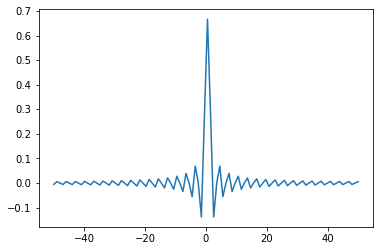

In [42]:
f_cut = 1
f_samp = 3
N = 100
h =  FIR_low_pass_filter(f_cut, f_samp, N)
x = np.linspace(-N/2, N/2, len(h))

fig = plt.figure()
subplot = fig.add_subplot(111)
subplot.plot(x, h)
plt.show()

In [43]:

def plot_filter(y_filtered, src_Func, h_filt):
    fig = plt.figure()
    subplot_func = fig.add_subplot(131)
    subplot_func.plot(src_Func.y, label = 'source')
    subplot_func.legend()
    
    subplot_filtered_func = fig.add_subplot(132)
    subplot_filtered_func.plot(y_filtered, label = 'filtered')
    #subplot_func.plot(y_filtered, label  = 'filtered')
    subplot_filtered_func.legend()
    #subplot_func.legend()
    
    subplot_filt = fig.add_subplot(133)
    subplot_filt.plot(h, label = 'Filter coefficients')
    subplot_filt.legend()
    
    fig.show()
    
    
    



sample_rate =  100


<ipython-input-43-d443ab7c8a57>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


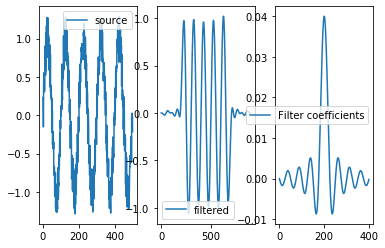

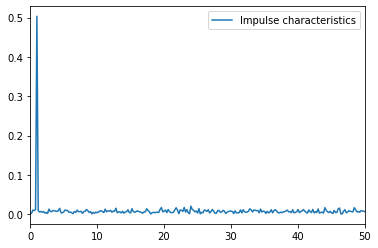

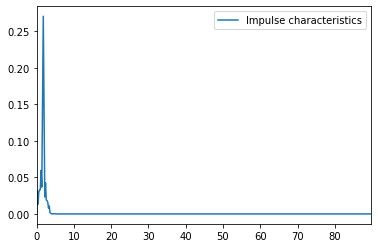

In [44]:
#noizy sin    
f=1
t_from = 0
t_to = 5
dt = 0.01
points_numb_func = int((t_to - t_from) / dt)
sample_rate = int(points_numb_func / (t_to - t_from))
print('sample_rate = ', sample_rate)

noize_level=0.3
noize_intensity=0.20
sin_Func = Function((FuncParams(t_from, t_to, 1, 1, 0, points_numb_func)))
sin_Func.reset_x()
sin_Func.y = np.sin(2*np.pi*f * sin_Func.x)
sin_Func.noize(noize_intensity, noize_level)

f_cut = f*2
N = 400
h =  FIR_low_pass_filter(f_cut, sample_rate, N)

y_filtered = np.convolve(h, sin_Func.y)
plot_filter(y_filtered, sin_Func, h)

plot_fft(sin_Func.y, sin_Func.From, sin_Func.To)
plot_fft(y_filtered, sin_Func.From, sin_Func.To)

<ipython-input-43-d443ab7c8a57>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


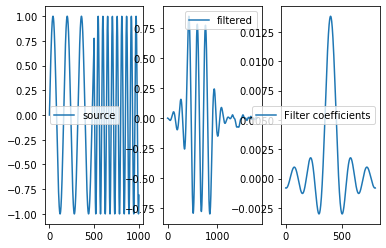

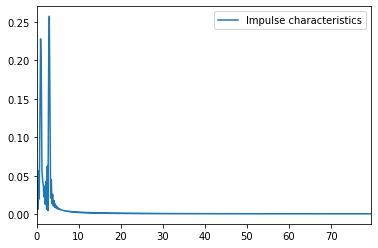

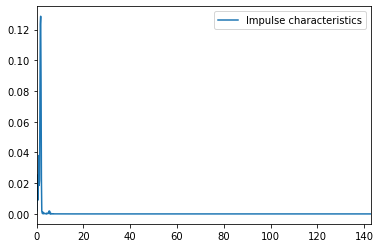

In [48]:
# Пример сначала с обной частотой, потом с другой
points_numb_left = 500
points_numb_right = 500
f_1 = 1
f_2 = 3
t_from = 0
t_middle = np.pi
t_to = 2*np.pi


x = np.linspace(t_from, t_middle, points_numb_left)
y = np.sin(2*np.pi*f_1*x)

x = np.linspace(t_middle, t_to, points_numb_right)
y_temp = np.sin(2*np.pi*f_2*x)
y_concat=np.concatenate([y,y_temp])

Double_freq_func = Function((FuncParams(from_=t_from, to=t_to, ampl=1, omega=1, shift=0, N=points_numb_left+points_numb_right)))

x = np.linspace(t_from, t_to, Double_freq_func.N)
Double_freq_func.x=x
Double_freq_func.y=np.concatenate([y,y_temp])


sample_rate = Double_freq_func.N / (Double_freq_func.To - Double_freq_func.From)

f_cut = f_1*1.1
N_filter = 800
h =  FIR_low_pass_filter(f_cut, sample_rate, N_filter)

y_filtered = np.convolve(h, Double_freq_func.y)
plot_filter(y_filtered, Double_freq_func, h)

plot_fft(Double_freq_func.y, Double_freq_func.From, Double_freq_func.To)
plot_fft(y_filtered, Double_freq_func.From, Double_freq_func.To)


sample_rate =  100


<ipython-input-43-d443ab7c8a57>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


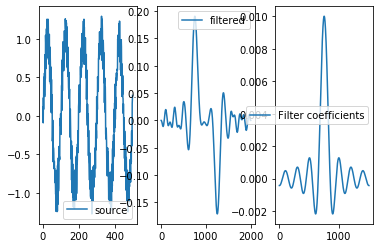

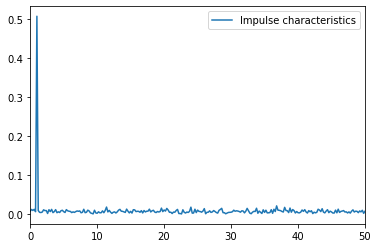

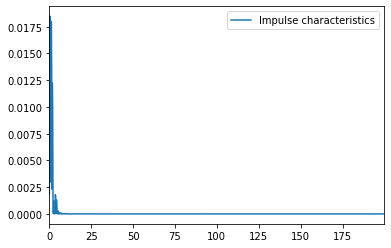

In [49]:
#noizy sin  - полностью срезать  
f=1
t_from = 0
t_to = 5
dt = 0.01
points_numb_func = int((t_to - t_from) / dt)
sample_rate = int(points_numb_func / (t_to - t_from))
print('sample_rate = ', sample_rate)

noize_level=0.3
noize_intensity=0.20
sin_Func = Function((FuncParams(t_from, t_to, 1, 1, 0, points_numb_func)))
sin_Func.reset_x()
sin_Func.y = np.sin(2*np.pi*f * sin_Func.x)
sin_Func.noize(noize_intensity, noize_level)

f_cut = f*0.5
N = 1500
h =  FIR_low_pass_filter(f_cut, sample_rate, N)

y_filtered = np.convolve(h, sin_Func.y)
plot_filter(y_filtered, sin_Func, h)

plot_fft(sin_Func.y, sin_Func.From, sin_Func.To)
plot_fft(y_filtered, sin_Func.From, sin_Func.To)


In [50]:
def get_numb_pts(t_to, t_from, dt):
        return int((t_to - t_from) / dt)
def get_sample_rate(N_pts, t_to, t_from):
    return N_pts / (t_to - t_from)



<ipython-input-43-d443ab7c8a57>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


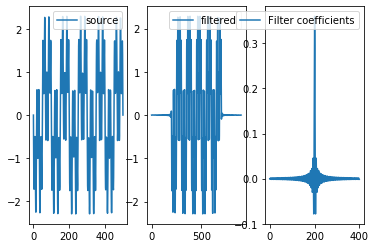

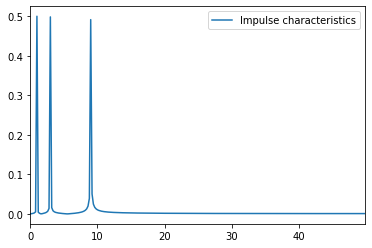

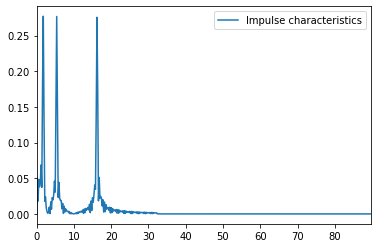

In [51]:
#Сумма синусов  - полное пропускание  
t_from = 0
t_to = 5
dt = 0.01
N_pts = get_numb_pts(t_to, t_from, dt)
sample_rate = get_sample_rate(N_pts, t_to, t_from)
sin_Func = Function((FuncParams(t_to, t_from, 1, 1, 0, N_pts)))
sin_Func.reset_x()
f = 1
f1=f
f2=3*f
f3=9*f
sin_Func.y = np.sin(f * 2 * np.pi * sin_Func.x) + 1*np.sin(f2 * 2 * np.pi * sin_Func.x) +1*np.sin(f3 * 2 * np.pi * sin_Func.x)

f_cut = f3*2
N = 400
h =  FIR_low_pass_filter(f_cut, sample_rate, N)

y_filtered = np.convolve(h, sin_Func.y)
plot_filter(y_filtered, sin_Func, h)



plot_fft(sin_Func.y, sin_Func.From, sin_Func.To)
plot_fft(y_filtered, sin_Func.From, sin_Func.To)

<ipython-input-43-d443ab7c8a57>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


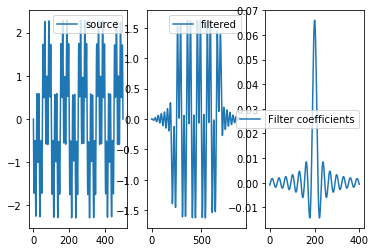

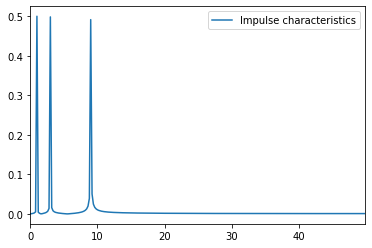

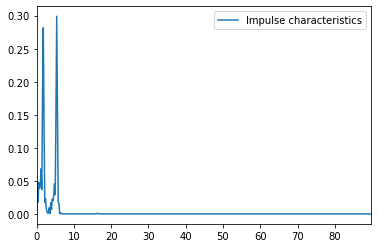

In [54]:
#Сумма синусов  - обрезка самых высоких частот
t_from = 0
t_to = 5
dt = 0.01
N_pts = get_numb_pts(t_to, t_from, dt)
sample_rate = get_sample_rate(N_pts, t_to, t_from)
sin_Func = Function((FuncParams(t_to, t_from, 1, 1, 0, N_pts)))
sin_Func.reset_x()
f = 1
f1=f
f2=3*f
f3=9*f
sin_Func.y = np.sin(f * 2 * np.pi * sin_Func.x) + 1*np.sin(f2 * 2 * np.pi * sin_Func.x) +1*np.sin(f3 * 2 * np.pi * sin_Func.x)

f_cut = f2*1.1
N = 400
h =  FIR_low_pass_filter(f_cut, sample_rate, N)

y_filtered = np.convolve(h, sin_Func.y)
plot_filter(y_filtered, sin_Func, h)



plot_fft(sin_Func.y, sin_Func.From, sin_Func.To)
plot_fft(y_filtered, sin_Func.From, sin_Func.To)


<ipython-input-43-d443ab7c8a57>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


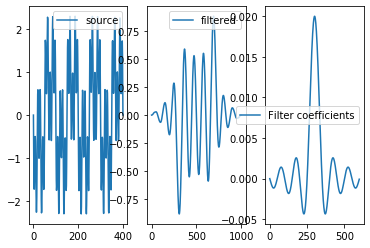

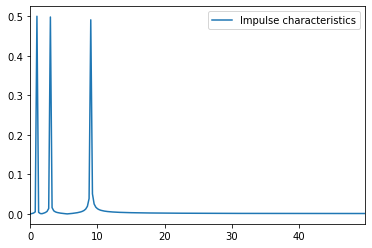

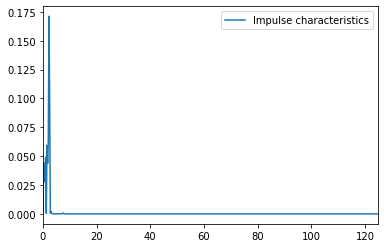

In [55]:
#Сумма синусов  - оставление только низких частот
t_from = 0
t_to = 4
dt = 0.01
N_pts = get_numb_pts(t_to, t_from, dt)
sample_rate = get_sample_rate(N_pts, t_to, t_from)
sin_Func = Function((FuncParams(t_to, t_from, 1, 1, 0, N_pts)))
sin_Func.reset_x()
f = 1
f1=f
f2=3*f
f3=9*f
sin_Func.y = np.sin(f * 2 * np.pi * sin_Func.x) + 1*np.sin(f2 * 2 * np.pi * sin_Func.x) +1*np.sin(f3 * 2 * np.pi * sin_Func.x)

f_cut = f1
N = 600
h =  FIR_low_pass_filter(f_cut, sample_rate, N)

y_filtered = np.convolve(h, sin_Func.y)
plot_filter(y_filtered, sin_Func, h)
plot_fft(sin_Func.y, sin_Func.From, sin_Func.To)
plot_fft(y_filtered, sin_Func.From, sin_Func.To)


<ipython-input-27-d443ab7c8a57>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-23-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-23-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-23-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-23-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


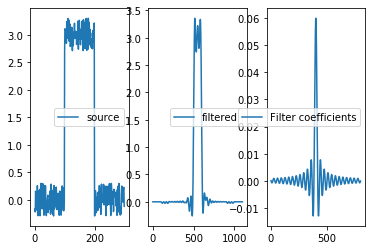

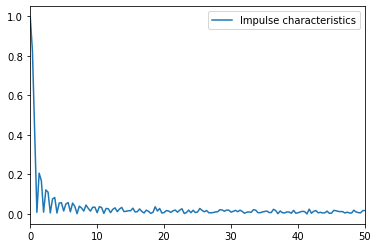

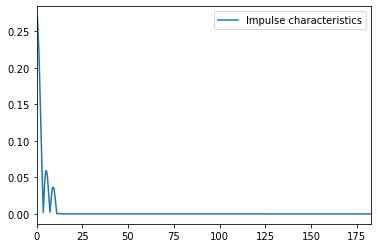

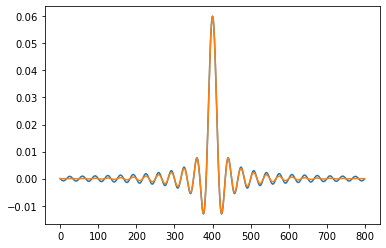

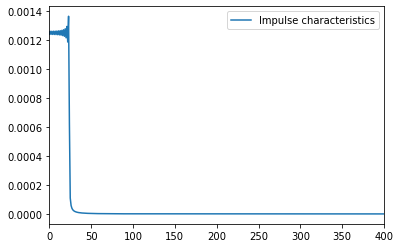

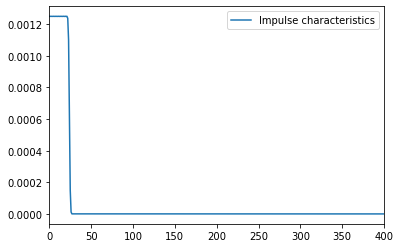

In [30]:
# Шумная ступенька
t_from = 0
t_to = 3
dt = 0.01
N_pts = get_numb_pts(t_to, t_from, dt)
sample_rate = get_sample_rate(N_pts, t_to, t_from)

meandr = Function((FuncParams(t_from, t_to, t_to, 1, 0, N_pts)))
meandr.calc(meander, 1, 2)
noize_level = 0.3
meandr.noize(0.2, noize_level)

f_cut = 3
N = 800
h =  FIR_low_pass_filter(f_cut, sample_rate, N)
y_filtered = np.convolve(h, meandr.y)
plot_filter(y_filtered, meandr, h)
plot_fft(meandr.y, meandr.From, meandr.To)
plot_fft(y_filtered, meandr.From, meandr.To)


gauss = signal.gaussian(len(h), 150)
h_smooth = smoothen_filter(h, gauss)


fig_smooth_filter = plt.figure()
sp_smooth_filt = fig_smooth_filter.add_subplot(111)
sp_smooth_filt.plot(h)
sp_smooth_filt.plot(h_smooth)

plot_fft(h, 0,1)
plot_fft(h_smooth, 0,1)


In [ ]:
def smoothen_filter(filt_src, gauss):
    res = []
    for i in range(len(filt_src)):
        res.append(gauss[i]*filt_src[i])
    return res

<ipython-input-23-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-23-2e5bdd889bd0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-27-d443ab7c8a57>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-27-d443ab7c8a57>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


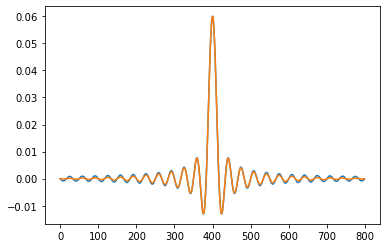

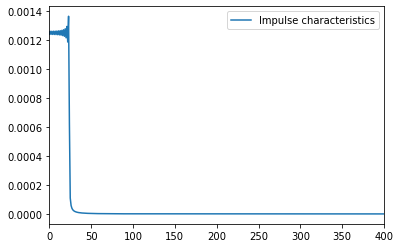

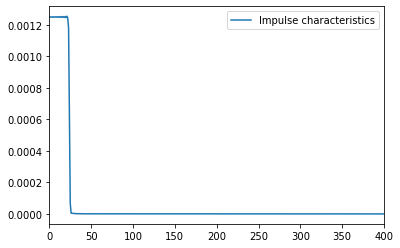

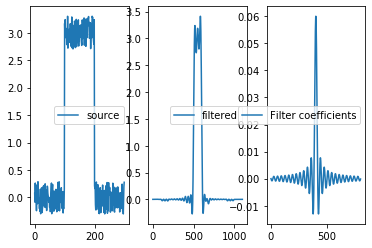

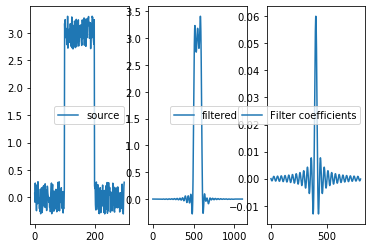

In [37]:
# Обоконивание фильтра
t_from = 0
t_to = 3
dt = 0.01
N_pts = get_numb_pts(t_to, t_from, dt)
sample_rate = get_sample_rate(N_pts, t_to, t_from)

meandr = Function((FuncParams(t_from, t_to, t_to, 1, 0, N_pts)))
meandr.calc(meander, 1, 2)
noize_level = 0.3
meandr.noize(0.2, noize_level)

f_cut = 3
N = 800
h =  FIR_low_pass_filter(f_cut, sample_rate, N)
#plt.plot(h)



gauss = signal.gaussian(len(h), 200)
h_smooth = smoothen_filter(h, gauss)
plt.plot(h)
plt.plot(h_smooth)

plot_fft(h, 0,1)
plot_fft(h_smooth, 0,1)


y_filtered = np.convolve(h, meandr.y)
y_filtered_smooth = np.convolve(h_smooth, meandr.y)
plot_filter(y_filtered, meandr, h)
plot_filter(y_filtered_smooth, meandr, h_smooth)
#plot_fft(meandr.y, meandr.From, meandr.To)
#plot_fft(y_filtered, meandr.From, meandr.To)